In [1]:
import pandas as pd
import datetime as dt
pd.set_option('display.max_columns', 999)
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math
from sklearn.utils import resample

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

import matplotlib.pyplot as plt
import gc

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

import h2o
from h2o.estimators import H2ORandomForestEstimator,H2OGradientBoostingEstimator,H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o import save_model

from sklearn.model_selection import StratifiedShuffleSplit

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /home/forutprojects2019/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpu2pgzwx9
  JVM stdout: /tmp/tmpu2pgzwx9/h2o_forutprojects2019_started_from_python.out
  JVM stderr: /tmp/tmpu2pgzwx9/h2o_forutprojects2019_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,2 days
H2O cluster name:,H2O_from_python_forutprojects2019_tgytj0
H2O cluster total nodes:,1
H2O cluster free memory:,7.361 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


In [2]:
#train = pd.read_csv("data/data/train.csv",parse_dates=["first_active_month"])
#merchant = pd.read_csv("/content/data/merchants.csv")
merchant_hist_trx = pd.read_csv("data/data/historical_transactions.csv",parse_dates=['purchase_date'])
merchant_trx = pd.read_csv("data/data/new_merchant_transactions.csv",parse_dates=['purchase_date'])
trx = pd.concat([merchant_hist_trx,merchant_trx],axis=0)
rfm_cust = pd.read_csv("data/rfm_customer_segmentation.csv")
end_date = dt.datetime(2017,4,30,0,0,0)

trx['purchase_amount_new'] = np.round(trx['purchase_amount'] / 0.00150265118 + 497.06,8)

In [3]:
train_cust = rfm_cust[rfm_cust['aon']>365]
train_cust['flag'] = 1
test_cust = rfm_cust[rfm_cust['aon']<=365]
test_cust['flag'] = 0

trx_with_flag = pd.merge(trx,train_cust[['card_id','customer_type','flag']],on='card_id',how='left')

train_trx = trx_with_flag[trx_with_flag['flag']==1]
test_trx = trx_with_flag[trx_with_flag['flag']!=1]

del trx

test_trx = test_trx.drop(['customer_type','flag'],axis=1)
test_trx = pd.merge(test_trx,test_cust[['card_id','customer_type','flag']],on='card_id',how='left')

train_trx_short = train_trx[train_trx['purchase_date']<dt.date(2017,5,1)]
test_trx_short = test_trx[test_trx['purchase_date']<dt.date(2017,9,1)]

In [5]:
train_cust = train_cust[train_cust['customer_type'].isin(['Low Spending Potential Customer','Loyal Customer','Low Spending New Customer',
       'Medium Spending Potential Customer', 'Impulsive Customer'])]

test_cust = test_cust[test_cust['customer_type'].isin(['Low Spending Potential Customer','Loyal Customer','Low Spending New Customer',
       'Medium Spending Potential Customer', 'Impulsive Customer'])]

In [6]:
def agg_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    history['installments'] = history['installments'].astype(int)
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    temp = grouped.agg(agg_func)
    temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
    temp.reset_index(inplace=True)

    final = temp.groupby('card_id').agg(['mean', 'std'])
    final.columns = ['_'.join(col).strip() for col in final.columns.values]
    final.reset_index(inplace=True)
    
    return final

In [7]:
def agg_hist_trans(trans, prefix):
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['year'] = trans['purchase_date'].dt.year
    trans['weekofyear'] = trans['purchase_date'].dt.weekofyear
    trans['month'] = trans['purchase_date'].dt.month
    trans['dayofweek'] = trans['purchase_date'].dt.dayofweek
    trans['weekend'] = (trans.purchase_date.dt.weekday >=5).astype(int)
    trans['hour'] = trans['purchase_date'].dt.hour
    trans['installments'] = trans['installments'].astype(int)
    trans['month_diff'] = ((dt.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans['category_2'] = trans['category_2'].fillna(0) 

    #trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)
    trans = pd.get_dummies(trans, columns=['category_1','category_2', 'category_3'])
    agg_func = {
        'category_1_Y': ['sum', 'mean'],
        'category_1_N': ['sum', 'mean'],
        'category_2_0.0': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_A': ['sum', 'mean'],
        'category_3_B': ['sum', 'mean'],
        'category_3_C': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
 #       'purchase_date': ['max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
#    trans.loc[:, 'purchase_date'] = pd.to_datetime(trans['purchase_date'])

    return agg_trans

In [8]:
month_agg_test = agg_per_month(test_trx_short)
cust_agg_test = agg_hist_trans(test_trx_short,'trx')

data_test = pd.merge(pd.merge(month_agg_test,cust_agg_test,on='card_id',how='left'),test_cust,on='card_id',how='left')
data_test = data_test.fillna(0)

In [9]:
month_agg = agg_per_month(train_trx_short)
cust_agg = agg_hist_trans(train_trx_short,'trx')

data = pd.merge(pd.merge(month_agg,cust_agg,on='card_id',how='left'),train_cust,on='card_id',how='left')
data = data.fillna(0)

In [10]:
def get_labels(row):
  if (row=='Loyal Customer'):
    output = 'Yes'
  else:
    output = 'No'
  return output

In [11]:
data['label'] = data['customer_type'].apply(get_labels)
data['label'] = data['label'].astype(str)

In [12]:
data_test['label'] = data_test['customer_type'].apply(get_labels)
data_test['label'] = data_test['label'].astype(str)

In [13]:
training_columns = ['month_lag_mean', 'month_lag_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean',
                    'purchase_amount_sum_std', 'purchase_amount_mean_mean', 'purchase_amount_mean_std', 'purchase_amount_min_mean', 'purchase_amount_min_std',
                    'purchase_amount_max_mean', 'purchase_amount_max_std', 'purchase_amount_std_mean', 'purchase_amount_std_std', 'installments_count_mean', 
                    'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'installments_mean_mean', 'installments_mean_std',
                    'installments_min_mean', 'installments_min_std', 'installments_max_mean', 'installments_max_std', 'installments_std_mean', 
                    'installments_std_std', 'trxtransactions_count', 'trxcategory_1_Y_sum', 'trxcategory_1_Y_mean', 'trxcategory_1_N_sum', 
                    'trxcategory_1_N_mean', 'trxcategory_2_0.0_sum', 'trxcategory_2_0.0_mean', 'trxcategory_2_1.0_mean', 'trxcategory_2_1.0_sum', 
                    'trxcategory_2_2.0_mean', 'trxcategory_2_2.0_sum', 'trxcategory_2_3.0_mean', 'trxcategory_2_3.0_sum', 'trxcategory_2_4.0_mean',
                    'trxcategory_2_4.0_sum', 'trxcategory_2_5.0_mean', 'trxcategory_2_5.0_sum', 'trxcategory_3_A_sum', 'trxcategory_3_A_mean',
                    'trxcategory_3_B_sum', 'trxcategory_3_B_mean', 'trxcategory_3_C_sum', 'trxcategory_3_C_mean', 'trxmerchant_id_nunique',
                    'trxpurchase_amount_sum', 'trxpurchase_amount_mean', 'trxpurchase_amount_max', 'trxpurchase_amount_min', 'trxpurchase_amount_std', 
                    'trxinstallments_sum', 'trxinstallments_mean', 'trxinstallments_max', 'trxinstallments_min', 'trxinstallments_std', 
                    'trxpurchase_month_mean', 'trxpurchase_month_max', 'trxpurchase_month_min', 'trxpurchase_month_std', 'trxmonth_lag_min', 
                    'trxmonth_lag_max', 'trxmerchant_category_id_nunique', 'trxstate_id_nunique', 'trxsubsector_id_nunique', 'trxcity_id_nunique']

response_column = 'label'

all_columns = training_columns+[response_column]

In [148]:
data_train_yes = data_train[data_train['label']=='Yes']
data_train_no = data_train[data_train['label']=='No']

In [151]:
df_minority_upsampled = resample(data_train_yes, 
                                 replace=True,     # sample with replacement
                                 n_samples=data_train_no.shape[0],    # to match majority class
                                 random_state=123)

In [152]:
data_train_up = pd.concat([df_minority_upsampled, data_train_no])

In [14]:
data_h2o = h2o.H2OFrame(data)

data_test = data_test[all_columns]
data_test_h2o = h2o.H2OFrame(data_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [83]:
rf_model = H2ORandomForestEstimator(nfolds=10,ntrees=100,balance_classes=True,max_depth=10,sample_rate=0.7,
                                   col_sample_rate_per_tree=0.7) 

rf_model.train(x=training_columns,y=response_column,training_frame=data_h2o)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [18]:
top_vars = []
for i in gbm_model.varimp()[:25]:
    top_vars.append(i[0])

In [85]:
h2o.save_model(rf_model, "data/rf_model")

'/home/forutprojects2019/data/rf_model/DRF_model_python_1573331770376_584'

In [86]:
rf_performance = rf_model.model_performance(data_test_h2o)

print(rf_performance)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.04163708156327534
RMSE: 0.20405166395615434
LogLoss: 0.2195035179547665
Mean Per-Class Error: 0.31342278954673275
AUC: 0.7553294323592333
pr_auc: 0.11249986965575683
Gini: 0.5106588647184667

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.008523690029199407: 


,,No,Yes,Error,Rate
0,No,67444.0,5270.0,0.0725,(5270.0/72714.0)
1,Yes,2191.0,1013.0,0.6838,(2191.0/3204.0)
2,Total,69635.0,6283.0,0.0983,(7461.0/75918.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.008524,0.213555,207.0
1,max f2,0.005590,0.300102,262.0
2,max f0point5,0.009314,0.183288,195.0
3,max accuracy,0.281013,0.957797,1.0
4,max precision,0.281013,0.500000,1.0
5,max recall,0.000673,1.000000,396.0
6,max specificity,0.350639,0.999986,0.0
7,max absolute_mcc,0.007953,0.179798,216.0
8,max min_per_class_accuracy,0.004689,0.685081,286.0
9,max mean_per_class_accuracy,0.004460,0.686577,291.0



Gains/Lift Table: Avg response rate:  4.22 %, avg score:  0.44 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010011,0.016719,0.935319,0.935319,0.039474,0.033745,0.039474,0.033745,0.009363,0.009363,-6.468066,-6.468066
1,,2,0.020008,0.012848,5.307126,3.119784,0.223979,0.014275,0.131666,0.024017,0.053059,0.062422,430.712597,211.978361
2,,3,0.030006,0.011404,5.463218,3.900585,0.230567,0.012060,0.164618,0.020033,0.054619,0.117041,446.321791,290.058547
3,,4,0.040004,0.010530,4.745195,4.111668,0.200264,0.010943,0.173527,0.017761,0.047441,0.164482,374.519499,311.166833
4,,5,0.050001,0.009907,3.902299,4.069805,0.164690,0.010206,0.171760,0.016251,0.039014,0.203496,290.229851,306.980539
5,,6,0.100003,0.007975,3.033628,3.551717,0.128030,0.008830,0.149895,0.012540,0.151685,0.355181,203.362795,255.171667
6,,7,0.150004,0.006812,1.785221,2.962885,0.075342,0.007359,0.125044,0.010813,0.089263,0.444444,78.522138,196.288491
7,,8,0.200005,0.005985,1.560508,2.612291,0.065859,0.006373,0.110248,0.009703,0.078027,0.522472,56.050820,161.229073
8,,9,0.300034,0.004918,1.266799,2.163715,0.053463,0.005403,0.091316,0.008270,0.126717,0.649189,26.679894,116.371471
9,,10,0.399997,0.004152,1.036587,1.882035,0.043748,0.004517,0.079428,0.007332,0.103620,0.752809,3.658706,88.203487


In [19]:
gbm_model = H2OGradientBoostingEstimator(nfolds=5,seed=11,ntrees=200,max_depth=15,balance_classes=True,
                                         sample_rate=0.5,col_sample_rate_per_tree=0.33)

gbm_model.train(x=top_vars, y=response_column, training_frame=data_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [20]:
gbm_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1573369415908_236


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,200.0,200.0,6843429.0,0.0,15.0,14.85,1.0,4879.0,2719.375




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0025352055670185957
RMSE: 0.05035082488915743
LogLoss: 0.021978755917764107
Mean Per-Class Error: 0.0003618454110105862
AUC: 0.999999524718622
pr_auc: 0.980207012776901
Gini: 0.9999990494372439

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08986629631006922: 


,,No,Yes,Error,Rate
0,No,158809.0,82.0,0.0005,(82.0/158891.0)
1,Yes,33.0,158916.0,0.0002,(33.0/158949.0)
2,Total,158842.0,158998.0,0.0004,(115.0/317840.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.089866,0.999638,363.0
1,max f2,0.041926,0.999829,368.0
2,max f0point5,0.269919,0.999681,354.0
3,max accuracy,0.089866,0.999638,363.0
4,max precision,0.999758,1.000000,0.0
5,max recall,0.041926,1.000000,368.0
6,max specificity,0.999758,1.000000,0.0
7,max absolute_mcc,0.089866,0.999276,363.0
8,max min_per_class_accuracy,0.101833,0.999591,361.0
9,max mean_per_class_accuracy,0.089866,0.999638,363.0



Gains/Lift Table: Avg response rate: 50.01 %, avg score: 48.05 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010018,9.995955e-01,1.999635,1.999635,1.000000,9.997582e-01,1.000000,0.999758,0.020032,0.020032,99.963510,99.963510
1,,2,0.020020,9.992634e-01,1.999635,1.999635,1.000000,9.994401e-01,1.000000,0.999599,0.020000,0.040032,99.963510,99.963510
2,,3,0.030047,9.988349e-01,1.999635,1.999635,1.000000,9.990489e-01,1.000000,0.999416,0.020050,0.060082,99.963510,99.963510
3,,4,0.040017,9.983954e-01,1.999635,1.999635,1.000000,9.986250e-01,1.000000,0.999219,0.019937,0.080019,99.963510,99.963510
4,,5,0.050050,9.978843e-01,1.999635,1.999635,1.000000,9.981247e-01,1.000000,0.998999,0.020063,0.100082,99.963510,99.963510
5,,6,0.100022,9.946566e-01,1.999635,1.999635,1.000000,9.963683e-01,1.000000,0.997685,0.099925,0.200008,99.963510,99.963510
6,,7,0.150044,9.899594e-01,1.999635,1.999635,1.000000,9.923711e-01,1.000000,0.995913,0.100026,0.300033,99.963510,99.963510
7,,8,0.200038,9.841702e-01,1.999635,1.999635,1.000000,9.871400e-01,1.000000,0.993721,0.099969,0.400003,99.963510,99.963510
8,,9,0.300009,9.685143e-01,1.999635,1.999635,1.000000,9.768338e-01,1.000000,0.988093,0.199907,0.599909,99.963510,99.963510
9,,10,0.400044,9.397227e-01,1.999635,1.999635,1.000000,9.558149e-01,1.000000,0.980022,0.200033,0.799942,99.963510,99.963510




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.03197477624841605
RMSE: 0.17881492177225045
LogLoss: 0.17453882644616867
Mean Per-Class Error: 0.11213204995744275
AUC: 0.9444240465529825
pr_auc: 0.6836477931341888
Gini: 0.888848093105965

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03682376951654761: 


,,No,Yes,Error,Rate
0,No,155655.0,3236.0,0.0204,(3236.0/158891.0)
1,Yes,3238.0,6433.0,0.3348,(3238.0/9671.0)
2,Total,158893.0,9669.0,0.0384,(6474.0/168562.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.036824,0.665253,351.0
1,max f2,0.002776,0.704245,388.0
2,max f0point5,0.273483,0.717638,244.0
3,max accuracy,0.234944,0.964595,257.0
4,max precision,0.999576,0.990415,0.0
5,max recall,0.000009,1.000000,399.0
6,max specificity,0.999576,0.999981,0.0
7,max absolute_mcc,0.036824,0.644881,351.0
8,max min_per_class_accuracy,0.000398,0.880981,395.0
9,max mean_per_class_accuracy,0.000597,0.887868,394.0



Gains/Lift Table: Avg response rate:  5.74 %, avg score:  3.10 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010002,9.774652e-01,16.716323,16.716323,0.959075,9.934458e-01,0.959075,0.993446,0.167201,0.167201,1571.632253,1571.632253
1,,2,0.020005,8.319257e-01,14.752129,15.734226,0.846382,9.203341e-01,0.902728,0.956890,0.147555,0.314755,1375.212879,1473.422566
2,,3,0.030001,4.680694e-01,12.619676,14.696453,0.724036,6.616041e-01,0.843188,0.858500,0.126150,0.440906,1161.967637,1369.645315
3,,4,0.040003,1.903445e-01,9.676239,13.441213,0.555160,3.136332e-01,0.771170,0.722263,0.096784,0.537690,867.623864,1244.121340
4,,5,0.050005,7.121055e-02,7.918802,12.336600,0.454330,1.203752e-01,0.707795,0.601871,0.079206,0.616896,691.880214,1133.660011
5,,6,0.100005,2.267355e-03,3.834189,8.085647,0.219981,1.664620e-02,0.463902,0.309276,0.191707,0.808603,283.418881,708.564665
6,,7,0.150004,4.538772e-04,1.447644,5.873067,0.083056,1.033984e-03,0.336959,0.206533,0.072381,0.880984,44.764410,487.306665
7,,8,0.200004,1.790079e-04,0.690733,4.577522,0.039630,2.860467e-04,0.262629,0.154973,0.034536,0.915521,-30.926696,357.752167
8,,9,0.300002,5.871495e-05,0.335026,3.163384,0.019222,1.028684e-04,0.181495,0.103350,0.033502,0.949023,-66.497379,216.338448
9,,10,0.400001,2.727612e-05,0.163377,2.413394,0.009374,4.019940e-05,0.138465,0.077523,0.016338,0.965360,-83.662302,141.339373




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.96191436,3.744778E-4,0.9614247,0.96206284,0.9617401,0.96243274,0.96191156
1,auc,0.94460064,0.0018611482,0.9455594,0.94412625,0.94733816,0.94287264,0.94310683
2,err,0.038085613,3.744778E-4,0.038575318,0.037937168,0.038259897,0.037567243,0.038088437
3,err_count,1284.0,18.61451,1304.0,1280.0,1299.0,1257.0,1280.0
4,f0point5,0.668516,0.009531196,0.6526663,0.6698439,0.6731579,0.67793053,0.66898125
5,f1,0.6662853,0.004765095,0.66041666,0.66649294,0.66320974,0.6727415,0.6685655
6,f2,0.66417235,0.0063061174,0.6683534,0.66317534,0.65355134,0.66763127,0.6681503
7,lift_top_group,16.712986,0.4208562,17.378914,16.714462,16.222006,16.68956,16.559992
8,logloss,0.17454019,0.0027987508,0.17022718,0.17487928,0.17715353,0.17677933,0.17366168
9,max_per_class_error,0.33717167,0.009904507,0.32624868,0.33901808,0.3527328,0.33573264,0.33212623



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-10 07:17:16,1 min 44.487 sec,0.0,0.667832,1.458884,0.500000,0.000000,1.000000,0.499909
1,,2019-11-10 07:17:16,1 min 44.711 sec,1.0,0.661546,1.387419,0.964724,0.721786,1.959980,0.102589
2,,2019-11-10 07:17:16,1 min 44.871 sec,2.0,0.654677,1.319083,0.980742,0.977604,1.982705,0.064853
3,,2019-11-10 07:17:17,1 min 45.104 sec,3.0,0.647845,1.259723,0.987009,0.985694,1.993349,0.051903
4,,2019-11-10 07:17:17,1 min 45.330 sec,4.0,0.640700,1.204503,0.989521,0.988784,1.997757,0.045982
5,,2019-11-10 07:17:17,1 min 45.540 sec,5.0,0.633014,1.151589,0.990622,0.989743,1.999008,0.043569
6,,2019-11-10 07:17:17,1 min 45.737 sec,6.0,0.625577,1.104886,0.991701,0.990575,1.999009,0.041238
7,,2019-11-10 07:17:17,1 min 45.959 sec,7.0,0.617742,1.061004,0.992632,0.991669,1.999635,0.038189
8,,2019-11-10 07:17:18,1 min 46.157 sec,8.0,0.609840,1.020063,0.992944,0.992188,1.999635,0.038123
9,,2019-11-10 07:17:18,1 min 46.354 sec,9.0,0.600776,0.976877,0.993449,0.992370,1.999635,0.036735



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,purchase_amount_count_mean,53842.535156,1.000000,0.196256
1,trxtransactions_count,37026.316406,0.687678,0.134961
2,trxinstallments_sum,23469.873047,0.435898,0.085548
3,trxmerchant_id_nunique,23215.939453,0.431182,0.084622
4,trxcategory_3_A_sum,10145.865234,0.188436,0.036982
5,trxpurchase_amount_min,9299.382812,0.172714,0.033896
6,purchase_amount_sum_mean,9212.169922,0.171095,0.033578
7,trxpurchase_amount_mean,8925.321289,0.165767,0.032533
8,trxmonth_lag_min,8462.151367,0.157165,0.030845
9,trxmonth_lag_max,8403.825195,0.156082,0.030632



See the whole table with table.as_data_frame()


In [56]:
gbm_performance = gbm_model.model_performance(data_test_h2o)

print(gbm_performance)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.041827339098533776
RMSE: 0.2045173320247792
LogLoss: 0.41781773502247255
Mean Per-Class Error: 0.1449498640410707
AUC: 0.9134220711521281
pr_auc: 0.4394166380355678
Gini: 0.8268441423042563

Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.6076153819138224e-05: 


,,No,Yes,Error,Rate
0,No,70654.0,2088.0,0.0287,(2088.0/72742.0)
1,Yes,1339.0,1837.0,0.4216,(1339.0/3176.0)
2,Total,71993.0,3925.0,0.0451,(3427.0/75918.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,4.607615e-05,0.517392,347.0
1,max f2,1.792326e-05,0.592390,368.0
2,max f0point5,1.317622e-04,0.526602,309.0
3,max accuracy,1.455817e-04,0.963092,304.0
4,max precision,2.782633e-04,0.648906,268.0
5,max recall,6.868622e-08,1.000000,399.0
6,max specificity,9.123163e-01,0.999986,0.0
7,max absolute_mcc,4.327180e-05,0.497386,349.0
8,max min_per_class_accuracy,4.300048e-06,0.849949,384.0
9,max mean_per_class_accuracy,4.871686e-06,0.855050,383.0



Gains/Lift Table: Avg response rate:  4.18 %, avg score:  0.01 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010011,3.835576e-04,15.254304,15.254304,0.638158,1.149582e-02,0.638158,0.011496,0.152708,0.152708,1425.430449,1425.430449
1,,2,0.020008,1.796001e-04,14.203620,14.729308,0.594203,2.609472e-04,0.616195,0.005882,0.142003,0.294710,1320.361954,1372.930786
2,,3,0.030006,1.086862e-04,10.959777,13.473349,0.458498,1.391585e-04,0.563652,0.003969,0.109572,0.404282,995.977738,1247.334929
3,,4,0.040004,7.102439e-05,9.164641,12.396527,0.383399,8.773949e-05,0.518604,0.002999,0.091625,0.495907,816.464143,1139.652701
4,,5,0.050001,4.817743e-05,7.180544,11.353605,0.300395,5.839683e-05,0.474974,0.002411,0.071788,0.567695,618.054380,1035.360518
5,,6,0.100003,1.249890e-05,3.690079,7.521842,0.154373,2.496604e-05,0.314673,0.001218,0.184509,0.752204,269.007911,652.184215
6,,7,0.150004,5.604212e-06,1.467216,5.503633,0.061380,8.351028e-06,0.230242,0.000815,0.073363,0.825567,46.721576,450.363335
7,,8,0.200005,3.292061e-06,0.868995,4.344974,0.036354,4.274436e-06,0.181770,0.000612,0.043451,0.869018,-13.100526,334.497370
8,,9,0.300008,1.590158e-06,0.396715,3.028887,0.016596,2.270995e-06,0.126712,0.000409,0.039673,0.908690,-60.328501,202.888746
9,,10,0.399997,9.452329e-07,0.267660,2.338649,0.011197,1.225835e-06,0.097836,0.000307,0.026763,0.935453,-73.233955,133.864890


In [217]:
xg_model = H2OXGBoostEstimator(nfolds=5,seed=11,ntrees=200,max_depth=15,
                                         sample_rate=0.7,col_sample_rate_per_tree=0.33)

xg_model.train(x=training_columns, y=response_column, training_frame=data_h2o)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [229]:
xg_performance = xg_model.model_performance(data_test_h2o)

print(xg_performance,xg_performance.recall())

H2OResponseError: Server error water.exceptions.H2OKeyNotFoundArgumentException:
  Error: Object 'XGBoost_model_python_1573331770376_4245' not found in function: predict for argument: model
  Request: POST /3/ModelMetrics/models/XGBoost_model_python_1573331770376_4245/frames/Key_Frame__upload_a75835c970c7f5d650472dfec2f54e67.hex


In [54]:
data[data['label']=='Yes'].shape

(9671, 86)

([[0.8452510190558964, 1.0]], [[0.0009773733302547096, 1.0]])

In [58]:
y_pred = gbm_model.predict(data_test_h2o,threshold=4.6076153819138224e-05)

TypeError: predict() got an unexpected keyword argument 'threshold'

In [53]:
y_pred[y_pred['predict']=='Yes'].shape

(9751, 3)

In [71]:
y_pred_pos = y_pred[y_pred['predict']=='Yes']

In [114]:
data_test['predicted'] = y_pred['predict']

In [117]:
data_test[data_test['label']=='Yes'].shape

(3204, 72)

In [25]:
y_pred['predict'].value_counts()

No     75904
Yes       14
Name: predict, dtype: int64

In [76]:
data_test.shape

(75918, 71)

In [121]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.model_selection import GridSearchCV   #Perforing grid search

In [128]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[training_columns], dtrain[response_column])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[training_columns])
    dtrain_predprob = alg.predict_proba(dtrain[training_columns])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[training_columns], dtrain[response_column], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[response_column].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[response_column], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, training_columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8996
AUC Score (Train): 0.963283
CV Score : Mean - 0.9627094 | Std - 0.0008440323 | Min - 0.9613944 | Max - 0.9636923


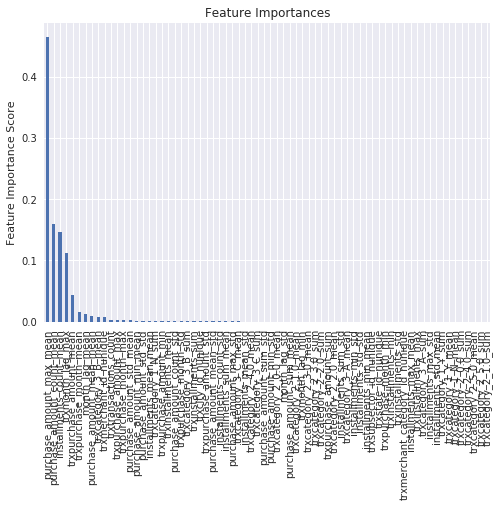

In [155]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, data_train_up, training_columns)

In [166]:
test_predictions = gbm0.predict(data_test[training_columns])
test_predprob = gbm0.predict_proba(data_test[training_columns])[:,1]

In [167]:
data_test['predicted'] = test_predictions

In [168]:
data_test['predicted'].value_counts()

No     75790
Yes      128
Name: predicted, dtype: int64

In [165]:
data_test['label'].value_counts()

No     72714
Yes     3204
Name: label, dtype: int64